#**ReadMe**


1.   QKULDA 구현 코드입니다.
2.   arcne 데이터셋 파일을 구글 드라이브에 업로드해주세요.
3.   구글 드라이브 마운트해주세요.
4.   arcne파일 업로드(train, train_label, valid, valid_label이 업로드 되어야 합니다.
5.   코드의 가장 마지막 부분(main 부분)에 파일의 경로를 지정해주세요
6.   umap-learn 을 pip을 이용해 install 한 후 전체 코드를 실행하시면 됩니다.




#**전체코드**


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 864.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.7 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Testing λ1: 0.1, λ2: 0.1
Initial Sigma: 1.0802619457244873
Optimization Sigma: 0.2870467306865422
Initial Sigma: 1.0827503204345703
Optimization Sigma: 0.2452183095033314
Initial Sigma: 1.091261863708496
Optimization Sigma: 0.2543924231877223
Initial Sigma: 1.08285653591156
Optimization Sigma: 0.26975930632152423
Initial Sigma: 1.0848419666290283
Optimization Sigma: 0.25471006782728384
Testing λ1: 0.1, λ2: 0.5
Initial Sigma: 1.0802619457244873
Optimization Sigma: 0.2870467306865422
Initial Sigma: 1.0827503204345703
Optimization Sigma: 0.2452183095033314
Initial Sigma: 1.091261863708496
Optimization Sigma: 0.2543924231877223
Initial Sigma: 1.08285653591156
Optimization Sigma: 0.26975930632152423
Initial Sigma: 1.0848419666290283
Optimization Sigma: 0.25471006782728384
Testing λ1: 0.1, λ2: 1
Initial Sigma: 1.0802619457244873
Optimization Sigma: 0.2870467306865422
Initial Sigma: 1.0827503204345703
Optimization Sigma: 0.2452183095033314
Initial Sigma: 1.091261863708496
Optimization Sigma: 

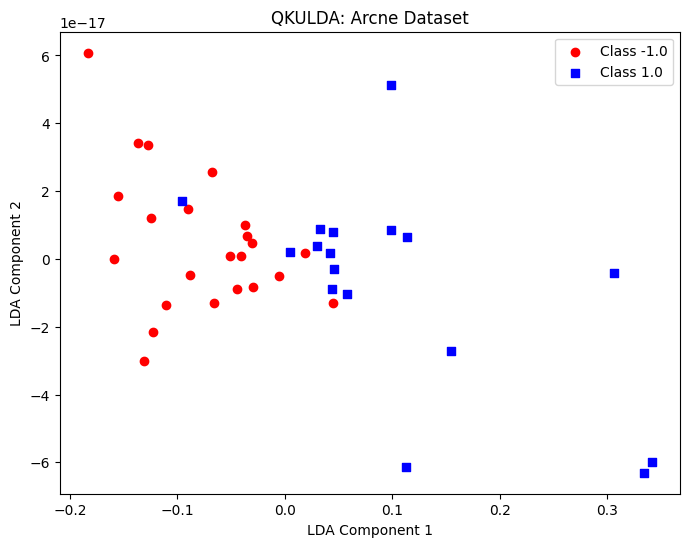

In [9]:
import numpy as np
from scipy.optimize import minimize
from sklearn.preprocessing import StandardScaler
from umap import UMAP
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Helper class for data loading and preprocessing
class DataLoader:
    def __init__(self, train_data_path, train_labels_path, valid_data_path, valid_labels_path):
        self.train_data_path = train_data_path
        self.train_labels_path = train_labels_path
        self.valid_data_path = valid_data_path
        self.valid_labels_path = valid_labels_path

    def load_data(self):
        train_data = np.genfromtxt(self.train_data_path)
        train_labels = np.genfromtxt(self.train_labels_path)
        valid_data = np.genfromtxt(self.valid_data_path)
        valid_labels = np.genfromtxt(self.valid_labels_path)

        X = np.vstack((train_data, valid_data))
        y = np.hstack((train_labels, valid_labels))

        return X, y

    def standardize_data(self, X):
        scaler = StandardScaler()
        return scaler.fit_transform(X)

class QKULDA:
    def __init__(self, n_components=100, lambda1=0.5, lambda2=0.5, reg_param=0.1, random_state=42):
        self.n_components = n_components
        self.lambda1 = lambda1
        self.lambda2 = lambda2
        self.reg_param = reg_param
        self.random_state = random_state
        self.umap = UMAP(n_components=self.n_components, random_state=self.random_state)
        self.weights = None
        self.means = None
        self.classes = None

    def fit_transform_umap(self, X):
        return self.umap.fit_transform(X)

    def compute_rbf_kernel(self, X, gamma=None):
        if gamma is None:
            gamma = 1.0 / X.shape[1]
        return rbf_kernel(X, gamma=gamma)

    def klda(self, X, y, num_components=2, gamma=None):
        K = self.compute_rbf_kernel(X, gamma=gamma)
        n_samples = K.shape[0]

        one_n = np.ones((n_samples, n_samples)) / n_samples
        K_centered = K - one_n @ K - K @ one_n + one_n @ K @ one_n

        unique_classes = np.unique(y)
        num_classes = len(unique_classes)
        N = np.zeros((n_samples, num_classes))
        for idx, cls in enumerate(unique_classes):
            N[:, idx] = (y == cls).astype(float) / np.sum(y == cls)

        M = K_centered @ N
        M_centered = M - np.mean(M, axis=0)

        eigvals, eigvecs = np.linalg.eigh(M_centered.T @ M_centered)
        sorted_indices = np.argsort(eigvals)[::-1]
        eigvals = eigvals[sorted_indices]
        eigvecs = eigvecs[:, sorted_indices]

        W = eigvecs[:, :num_components]
        Z = K_centered @ M_centered @ W

        return Z

    def calculate_Q1(self, K_centered, y):
        unique_classes = np.unique(y)
        num_classes = len(unique_classes)
        covariance_matrices = []

        for cls in unique_classes:
            K_c = K_centered[y == cls]
            covariance_c = np.cov(K_c, rowvar=False) + 1e-10 * np.eye(K_c.shape[1])
            covariance_matrices.append(covariance_c)

        Q1_num = 0
        for i in range(num_classes):
            for j in range(num_classes):
                Q1_num += np.trace(np.linalg.inv(covariance_matrices[i]) @ covariance_matrices[j])

        Q1 = 0.5 * (Q1_num / num_classes)
        return Q1

    def calculate_Q2(self, K_centered, y):
        unique_classes = np.unique(y)
        mean_overall = np.mean(K_centered, axis=0)

        S_B = np.zeros((K_centered.shape[1], K_centered.shape[1]))
        for cls in unique_classes:
            K_c = K_centered[y == cls]
            n_c = K_c.shape[0]
            mean_c = np.mean(K_c, axis=0)
            mean_diff = (mean_c - mean_overall).reshape(-1, 1)
            S_B += n_c * np.dot(mean_diff, mean_diff.T)

        Q2 = np.trace(S_B)
        return Q2

    def calculate_Q(self, X, y, sigma):
        K = rbf_kernel(X, gamma=1.0 / (2 * sigma ** 2))
        n_samples = K.shape[0]

        one_n = np.ones((n_samples, n_samples)) / n_samples
        K_centered = K - one_n @ K - K @ one_n + one_n @ K @ one_n

        Q1 = self.calculate_Q1(K_centered, y)
        Q2 = self.calculate_Q2(K_centered, y)

        Q = self.lambda1 * Q1 + self.lambda2 * Q2
        return Q

    def optimize_sigma(self, X, y):
        def objective(sigma):
            Q_value = self.calculate_Q(X, y, sigma)
            #print(f'Sigma: {sigma}, Q: {Q_value}')
            return -Q_value

        initial_sigma = np.sqrt(np.mean(np.var(X, axis=0)))
        print(f'Initial Sigma: {initial_sigma}')
        result = minimize(objective, initial_sigma, method='Nelder-Mead', bounds=[(1e-3, 1e3)])
        optimal_sigma = result.x[0]
        print(f'Optimization Sigma: {optimal_sigma}')
        return result.x[0]

    def fit(self, X, y):
        optimal_sigma = self.optimize_sigma(X, y)
        gamma_optimal = 1.0 / (2 * optimal_sigma ** 2)
        Z = self.klda(X, y, num_components=2, gamma=gamma_optimal)

        n_samples, n_features = Z.shape
        self.classes = np.unique(y)
        n_classes = len(self.classes)

        self.means = np.zeros((n_classes, n_features))
        for idx, cls in enumerate(self.classes):
            Z_c = Z[y == cls]
            self.means[idx, :] = np.mean(Z_c, axis=0)

        SW = np.zeros((n_features, n_features))
        for idx, cls in enumerate(self.classes):
            Z_c = Z[y == cls]
            SW += np.dot((Z_c - self.means[idx]).T, (Z_c - self.means[idx]))

        overall_mean = np.mean(Z, axis=0)
        SB = np.zeros((n_features, n_features))
        for idx, cls in enumerate(self.classes):
            n_c = Z[y == cls].shape[0]
            mean_diff = (self.means[idx] - overall_mean).reshape(n_features, 1)
            SB += n_c * np.dot(mean_diff, mean_diff.T)

        A = np.linalg.pinv(SW + self.reg_param * np.eye(n_features)).dot(SB)
        eigvals, eigvecs = np.linalg.eig(A)
        eigvecs = eigvecs.T
        idxs = np.argsort(abs(eigvals))[::-1]
        self.weights = eigvecs[idxs]

    def predict(self, X):
        Z = self.klda(X, np.zeros(X.shape[0]), num_components=2, gamma=1.0 / (2 * self.optimize_sigma(X, np.zeros(X.shape[0])) ** 2))
        projected_means = np.dot(self.means, self.weights.T)
        projections = np.dot(Z, self.weights.T)
        y_pred = np.zeros(Z.shape[0])
        for i, projection in enumerate(projections):
            distances = np.linalg.norm(projection - projected_means, axis=1)
            y_pred[i] = self.classes[np.argmin(distances)]
        return y_pred

    def cross_validate(self, X_umap, y):
        best_lambda1, best_lambda2, best_score = self.find_best_params(X_umap, y)
        cv = StratifiedKFold(n_splits=5)

        accuracy_scores = []
        conf_matrices = []
        class_reports = []

        for train_index, test_index in cv.split(X_umap, y):
            X_train, X_test = X_umap[train_index], X_umap[test_index]
            y_train, y_test = y[train_index], y[test_index]

            optimal_sigma = self.optimize_sigma(X_train, y_train)
            gamma_optimal = 1.0 / (2 * optimal_sigma ** 2)

            Z_train_klda = self.klda(X_train, y_train, num_components=2, gamma=gamma_optimal)
            Z_test_klda = self.klda(X_test, y_test, num_components=2, gamma=gamma_optimal)

            self.fit_lda(Z_train_klda, y_train)
            y_pred = self.predict_lda(Z_test_klda)

            accuracy = accuracy_score(y_test, y_pred)
            conf_matrix = confusion_matrix(y_test, y_pred)
            class_report = classification_report(y_test, y_pred)

            accuracy_scores.append(accuracy)
            conf_matrices.append(conf_matrix)
            class_reports.append(class_report)

        print(f'Best λ1: {best_lambda1}, Best λ2: {best_lambda2}, Best Accuracy: {best_score}')
        print(f'Mean Accuracy: {np.mean(accuracy_scores)}')
        print('Confusion Matrices:')
        for cm in conf_matrices:
            print(cm)
        print('Classification Reports:')
        for cr in class_reports:
            print(cr)

        return Z_test_klda, y[test_index]

    def find_best_params(self, X_umap, y):
        lambda1_values = [0.1, 0.5, 1, 2, 5]
        lambda2_values = [0.1, 0.5, 1, 2, 5]
        best_lambda1 = 0
        best_lambda2 = 0
        best_score = -np.inf

        for lambda1 in lambda1_values:
            for lambda2 in lambda2_values:
                cv = StratifiedKFold(n_splits=5)
                temp_scores = []

                print(f'Testing λ1: {lambda1}, λ2: {lambda2}')  # 초기 람다 값 출력

                for train_index, test_index in cv.split(X_umap, y):
                    X_train, X_test = X_umap[train_index], X_umap[test_index]
                    y_train, y_test = y[train_index], y[test_index]

                    self.lambda1 = lambda1
                    self.lambda2 = lambda2
                    optimal_sigma = self.optimize_sigma(X_train, y_train)
                    gamma_optimal = 1.0 / (2 * optimal_sigma ** 2)

                    Z_train_klda = self.klda(X_train, y_train, num_components=2, gamma=gamma_optimal)
                    Z_test_klda = self.klda(X_test, y_test, num_components=2, gamma=gamma_optimal)

                    self.fit_lda(Z_train_klda, y_train)
                    y_pred = self.predict_lda(Z_test_klda)

                    accuracy = accuracy_score(y_test, y_pred)
                    temp_scores.append(accuracy)

                mean_score = np.mean(temp_scores)
                if mean_score > best_score:
                    best_score = mean_score
                    best_lambda1 = lambda1
                    best_lambda2 = lambda2

        self.lambda1 = best_lambda1
        self.lambda2 = best_lambda2
        print(f'Best λ1: {best_lambda1}, Best λ2: {best_lambda2}, Best Accuracy: {best_score}')
        return best_lambda1, best_lambda2, best_score

    def fit_lda(self, X, y):
        n_samples, n_features = X.shape
        self.classes = np.unique(y)
        n_classes = len(self.classes)

        self.means = np.zeros((n_classes, n_features))
        for idx, cls in enumerate(self.classes):
            X_c = X[y == cls]
            self.means[idx, :] = np.mean(X_c, axis=0)

        SW = np.zeros((n_features, n_features))
        for idx, cls in enumerate(self.classes):
            X_c = X[y == cls]
            SW += np.dot((X_c - self.means[idx]).T, (X_c - self.means[idx]))

        overall_mean = np.mean(X, axis=0)
        SB = np.zeros((n_features, n_features))
        for idx, cls in enumerate(self.classes):
            n_c = X[y == cls].shape[0]
            mean_diff = (self.means[idx] - overall_mean).reshape(n_features, 1)
            SB += n_c * np.dot(mean_diff, mean_diff.T)

        A = np.linalg.pinv(SW + self.reg_param * np.eye(n_features)).dot(SB)
        eigvals, eigvecs = np.linalg.eig(A)
        eigvecs = eigvecs.T
        idxs = np.argsort(abs(eigvals))[::-1]
        self.weights = eigvecs[idxs]

    def predict_lda(self, X):
        projected_means = np.dot(self.means, self.weights.T)
        projections = np.dot(X, self.weights.T)
        y_pred = np.zeros(X.shape[0])
        for i, projection in enumerate(projections):
            distances = np.linalg.norm(projection - projected_means, axis=1)
            y_pred[i] = self.classes[np.argmin(distances)]
        return y_pred

# Visualization function
def plot_lda(Z_test_klda, y_test):
    plt.figure(figsize=(8, 6))
    colors = ['r', 'b']
    markers = ['o', 's']
    for idx, cls in enumerate(np.unique(y_test)):
        plt.scatter(Z_test_klda[y_test == cls, 0], Z_test_klda[y_test == cls, 1],
                    c=colors[idx], label=f'Class {cls}', marker=markers[idx])
    plt.xlabel('LDA Component 1')
    plt.ylabel('LDA Component 2')
    plt.legend(loc='best')
    plt.title('QKULDA: Arcne Dataset')
    plt.show()

# Execution code
if __name__ == "__main__":
    train_data_path = '/content/drive/MyDrive/arcene/arcene_train.data'
    train_labels_path = '/content/drive/MyDrive/arcene/arcene_train.labels'
    valid_data_path = '/content/drive/MyDrive/arcene/arcene_valid.data'
    valid_labels_path = '/content/drive/MyDrive/arcene/arcene_valid.labels'

    data_loader = DataLoader(train_data_path, train_labels_path, valid_data_path, valid_labels_path)
    X, y = data_loader.load_data()
    X = data_loader.standardize_data(X)

    qkulda = QKULDA(n_components=100)
    X_umap = qkulda.fit_transform_umap(X)
    Z_test_klda, y_test = qkulda.cross_validate(X_umap, y)

    # Plotting the final LDA results
    plot_lda(Z_test_klda, y_test)


#**코드설명-세분화**
여기부터는 위의 전체 코드를 세분화 해서 설명한 부분으로, 실행하지 않고 무시하면 됩니다.

In [10]:
import numpy as np
from scipy.optimize import minimize
from sklearn.preprocessing import StandardScaler
from umap import UMAP
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

# **데이터 전처리**

# **데이터 전처리**

In [11]:
class DataLoader:
    def __init__(self, train_data_path, train_labels_path, valid_data_path, valid_labels_path):
        self.train_data_path = train_data_path
        self.train_labels_path = train_labels_path
        self.valid_data_path = valid_data_path
        self.valid_labels_path = valid_labels_path

    def load_data(self):
        train_data = np.genfromtxt(self.train_data_path)
        train_labels = np.genfromtxt(self.train_labels_path)
        valid_data = np.genfromtxt(self.valid_data_path)
        valid_labels = np.genfromtxt(self.valid_labels_path)

        X = np.vstack((train_data, valid_data))
        y = np.hstack((train_labels, valid_labels))

        return X, y

    def standardize_data(self, X):
        scaler = StandardScaler()
        return scaler.fit_transform(X)

# **QKULDA**

In [12]:
class QKULDA:
    def __init__(self, n_components=100, lambda1=0.5, lambda2=0.5, reg_param=0.1, random_state=42):
        self.n_components = n_components
        self.lambda1 = lambda1
        self.lambda2 = lambda2
        self.reg_param = reg_param
        self.random_state = random_state
        self.umap = UMAP(n_components=self.n_components, random_state=self.random_state)
        self.weights = None
        self.means = None
        self.classes = None

    def fit_transform_umap(self, X):
        return self.umap.fit_transform(X)

    def compute_rbf_kernel(self, X, gamma=None):
        if gamma is None:
            gamma = 1.0 / X.shape[1]
        return rbf_kernel(X, gamma=gamma)

    def klda(self, X, y, num_components=2, gamma=None):
        K = self.compute_rbf_kernel(X, gamma=gamma)
        n_samples = K.shape[0]

        one_n = np.ones((n_samples, n_samples)) / n_samples
        K_centered = K - one_n @ K - K @ one_n + one_n @ K @ one_n

        unique_classes = np.unique(y)
        num_classes = len(unique_classes)
        N = np.zeros((n_samples, num_classes))
        for idx, cls in enumerate(unique_classes):
            N[:, idx] = (y == cls).astype(float) / np.sum(y == cls)

        M = K_centered @ N
        M_centered = M - np.mean(M, axis=0)

        eigvals, eigvecs = np.linalg.eigh(M_centered.T @ M_centered)
        sorted_indices = np.argsort(eigvals)[::-1]
        eigvals = eigvals[sorted_indices]
        eigvecs = eigvecs[:, sorted_indices]

        W = eigvecs[:, :num_components]
        Z = K_centered @ M_centered @ W

        return Z

    def calculate_Q1(self, K_centered, y):
        unique_classes = np.unique(y)
        num_classes = len(unique_classes)
        covariance_matrices = []

        for cls in unique_classes:
            K_c = K_centered[y == cls]
            covariance_c = np.cov(K_c, rowvar=False) + 1e-10 * np.eye(K_c.shape[1])
            covariance_matrices.append(covariance_c)

        Q1_num = 0
        for i in range(num_classes):
            for j in range(num_classes):
                Q1_num += np.trace(np.linalg.inv(covariance_matrices[i]) @ covariance_matrices[j])

        Q1 = 0.5 * (Q1_num / num_classes)
        return Q1

    def calculate_Q2(self, K_centered, y):
        unique_classes = np.unique(y)
        mean_overall = np.mean(K_centered, axis=0)

        S_B = np.zeros((K_centered.shape[1], K_centered.shape[1]))
        for cls in unique_classes:
            K_c = K_centered[y == cls]
            n_c = K_c.shape[0]
            mean_c = np.mean(K_c, axis=0)
            mean_diff = (mean_c - mean_overall).reshape(-1, 1)
            S_B += n_c * np.dot(mean_diff, mean_diff.T)

        Q2 = np.trace(S_B)
        return Q2

    def calculate_Q(self, X, y, sigma):
        K = rbf_kernel(X, gamma=1.0 / (2 * sigma ** 2))
        n_samples = K.shape[0]

        one_n = np.ones((n_samples, n_samples)) / n_samples
        K_centered = K - one_n @ K - K @ one_n + one_n @ K @ one_n

        Q1 = self.calculate_Q1(K_centered, y)
        Q2 = self.calculate_Q2(K_centered, y)

        Q = self.lambda1 * Q1 + self.lambda2 * Q2
        return Q

    def optimize_sigma(self, X, y):
        def objective(sigma):
            Q_value = self.calculate_Q(X, y, sigma)
            return -Q_value

        initial_sigma = np.sqrt(np.mean(np.var(X, axis=0)))
        result = minimize(objective, initial_sigma, method='Nelder-Mead', bounds=[(1e-3, 1e3)])
        return result.x[0]

    def fit(self, X, y):
        optimal_sigma = self.optimize_sigma(X, y)
        gamma_optimal = 1.0 / (2 * optimal_sigma ** 2)
        Z = self.klda(X, y, num_components=2, gamma=gamma_optimal)

        n_samples, n_features = Z.shape
        self.classes = np.unique(y)
        n_classes = len(self.classes)

        self.means = np.zeros((n_classes, n_features))
        for idx, cls in enumerate(self.classes):
            Z_c = Z[y == cls]
            self.means[idx, :] = np.mean(Z_c, axis=0)

        SW = np.zeros((n_features, n_features))
        for idx, cls in enumerate(self.classes):
            Z_c = Z[y == cls]
            SW += np.dot((Z_c - self.means[idx]).T, (Z_c - self.means[idx]))

        overall_mean = np.mean(Z, axis=0)
        SB = np.zeros((n_features, n_features))
        for idx, cls in enumerate(self.classes):
            n_c = Z[y == cls].shape[0]
            mean_diff = (self.means[idx] - overall_mean).reshape(n_features, 1)
            SB += n_c * np.dot(mean_diff, mean_diff.T)

        A = np.linalg.pinv(SW + self.reg_param * np.eye(n_features)).dot(SB)
        eigvals, eigvecs = np.linalg.eig(A)
        eigvecs = eigvecs.T
        idxs = np.argsort(abs(eigvals))[::-1]
        self.weights = eigvecs[idxs]

    def predict(self, X):
        Z = self.klda(X, np.zeros(X.shape[0]), num_components=2, gamma=1.0 / (2 * self.optimize_sigma(X, np.zeros(X.shape[0])) ** 2))
        projected_means = np.dot(self.means, self.weights.T)
        projections = np.dot(Z, self.weights.T)
        y_pred = np.zeros(Z.shape[0])
        for i, projection in enumerate(projections):
            distances = np.linalg.norm(projection - projected_means, axis=1)
            y_pred[i] = self.classes[np.argmin(distances)]
        return y_pred

    def cross_validate(self, X_umap, y):
        best_lambda1, best_lambda2, best_score = self.find_best_params(X_umap, y)
        cv = StratifiedKFold(n_splits=5)

        accuracy_scores = []
        conf_matrices = []
        class_reports = []

        for train_index, test_index in cv.split(X_umap, y):
            X_train, X_test = X_umap[train_index], X_umap[test_index]
            y_train, y_test = y[train_index], y[test_index]

            optimal_sigma = self.optimize_sigma(X_train, y_train)
            gamma_optimal = 1.0 / (2 * optimal_sigma ** 2)

            Z_train_klda = self.klda(X_train, y_train, num_components=2, gamma=gamma_optimal)
            Z_test_klda = self.klda(X_test, y_test, num_components=2, gamma=gamma_optimal)

            self.fit_lda(Z_train_klda, y_train)
            y_pred = self.predict_lda(Z_test_klda)

            accuracy = accuracy_score(y_test, y_pred)
            conf_matrix = confusion_matrix(y_test, y_pred)
            class_report = classification_report(y_test, y_pred)

            accuracy_scores.append(accuracy)
            conf_matrices.append(conf_matrix)
            class_reports.append(class_report)

        print(f'Best λ1: {best_lambda1}, Best λ2: {best_lambda2}, Best Accuracy: {best_score}')
        print(f'Mean Accuracy: {np.mean(accuracy_scores)}')
        print('Confusion Matrices:')
        for cm in conf_matrices:
            print(cm)
        print('Classification Reports:')
        for cr in class_reports:
            print(cr)

        return Z_test_klda, y[test_index]

    def find_best_params(self, X_umap, y):
        lambda1_values = [0.1, 0.5, 1, 2, 5]
        lambda2_values = [0.1, 0.5, 1, 2, 5]
        best_lambda1 = 0
        best_lambda2 = 0
        best_score = -np.inf

        for lambda1 in lambda1_values:
            for lambda2 in lambda2_values:
                cv = StratifiedKFold(n_splits=5)
                temp_scores = []

                for train_index, test_index in cv.split(X_umap, y):
                    X_train, X_test = X_umap[train_index], X_umap[test_index]
                    y_train, y_test = y[train_index], y[test_index]

                    self.lambda1 = lambda1
                    self.lambda2 = lambda2
                    optimal_sigma = self.optimize_sigma(X_train, y_train)
                    gamma_optimal = 1.0 / (2 * optimal_sigma ** 2)

                    Z_train_klda = self.klda(X_train, y_train, num_components=2, gamma=gamma_optimal)
                    Z_test_klda = self.klda(X_test, y_test, num_components=2, gamma=gamma_optimal)

                    self.fit_lda(Z_train_klda, y_train)
                    y_pred = self.predict_lda(Z_test_klda)

                    accuracy = accuracy_score(y_test, y_pred)
                    temp_scores.append(accuracy)

                mean_score = np.mean(temp_scores)
                if mean_score > best_score:
                    best_score = mean_score
                    best_lambda1 = lambda1
                    best_lambda2 = lambda2

        self.lambda1 = best_lambda1
        self.lambda2 = best_lambda2
        return best_lambda1, best_lambda2, best_score

    def fit_lda(self, X, y):
        n_samples, n_features = X.shape
        self.classes = np.unique(y)
        n_classes = len(self.classes)

        self.means = np.zeros((n_classes, n_features))
        for idx, cls in enumerate(self.classes):
            X_c = X[y == cls]
            self.means[idx, :] = np.mean(X_c, axis=0)

        SW = np.zeros((n_features, n_features))
        for idx, cls in enumerate(self.classes):
            X_c = X[y == cls]
            SW += np.dot((X_c - self.means[idx]).T, (X_c - self.means[idx]))

        overall_mean = np.mean(X, axis=0)
        SB = np.zeros((n_features, n_features))
        for idx, cls in enumerate(self.classes):
            n_c = X[y == cls].shape[0]
            mean_diff = (self.means[idx] - overall_mean).reshape(n_features, 1)
            SB += n_c * np.dot(mean_diff, mean_diff.T)

        A = np.linalg.pinv(SW + self.reg_param * np.eye(n_features)).dot(SB)
        eigvals, eigvecs = np.linalg.eig(A)
        eigvecs = eigvecs.T
        idxs = np.argsort(abs(eigvals))[::-1]
        self.weights = eigvecs[idxs]

    def predict_lda(self, X):
        projected_means = np.dot(self.means, self.weights.T)
        projections = np.dot(X, self.weights.T)
        y_pred = np.zeros(X.shape[0])
        for i, projection in enumerate(projections):
            distances = np.linalg.norm(projection - projected_means, axis=1)
            y_pred[i] = self.classes[np.argmin(distances)]
        return y_pred


#**결과시각화**

In [13]:
def plot_lda(Z_test_klda, y_test):
    plt.figure(figsize=(8, 6))
    colors = ['r', 'b']
    markers = ['o', 's']
    for idx, cls in enumerate(np.unique(y_test)):
        plt.scatter(Z_test_klda[y_test == cls, 0], Z_test_klda[y_test == cls, 1],
                    c=colors[idx], label=f'Class {cls}', marker=markers[idx])
    plt.xlabel('LDA Component 1')
    plt.ylabel('LDA Component 2')
    plt.legend(loc='best')
    plt.title('QKULDA: Arcne Dataset')
    plt.show()

#**실행코드**

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Best λ1: 0.1, Best λ2: 0.1, Best Accuracy: 0.925
Mean Accuracy: 0.925
Confusion Matrices:
[[21  1]
 [ 3 15]]
[[20  2]
 [ 1 17]]
[[19  3]
 [ 0 18]]
[[22  1]
 [ 0 17]]
[[21  2]
 [ 2 15]]
Classification Reports:
              precision    recall  f1-score   support

        -1.0       0.88      0.95      0.91        22
         1.0       0.94      0.83      0.88        18

    accuracy                           0.90        40
   macro avg       0.91      0.89      0.90        40
weighted avg       0.90      0.90      0.90        40

              precision    recall  f1-score   support

        -1.0       0.95      0.91      0.93        22
         1.0       0.89      0.94      0.92        18

    accuracy                           0.93        40
   macro avg       0.92      0.93      0.92        40
weighted avg       0.93      0.93      0.93        40

              precision    recall  f1-score   support

        -1.0       1.00      0.86      0.93        22
         1.0       0.86     

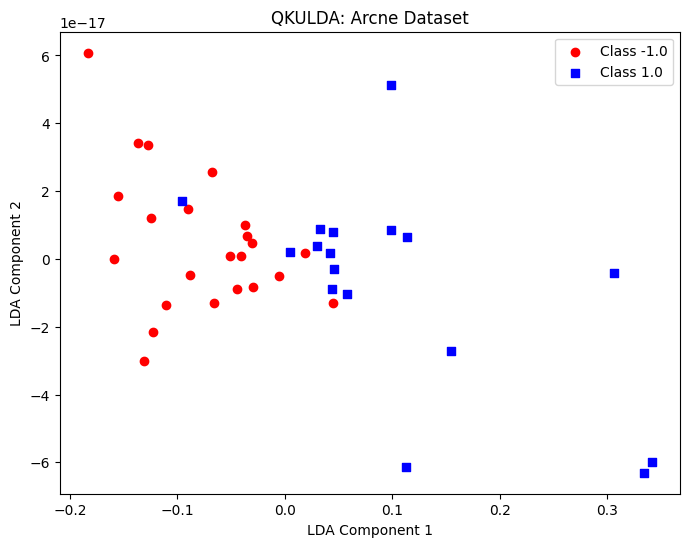

In [14]:
if __name__ == "__main__":
    train_data_path = '/content/drive/MyDrive/arcene/arcene_train.data'
    train_labels_path = '/content/drive/MyDrive/arcene/arcene_train.labels'
    valid_data_path = '/content/drive/MyDrive/arcene/arcene_valid.data'
    valid_labels_path = '/content/drive/MyDrive/arcene/arcene_valid.labels'

    data_loader = DataLoader(train_data_path, train_labels_path, valid_data_path, valid_labels_path)
    X, y = data_loader.load_data()
    X = data_loader.standardize_data(X)

    qkulda = QKULDA(n_components=100)
    X_umap = qkulda.fit_transform_umap(X)
    Z_test_klda, y_test = qkulda.cross_validate(X_umap, y)

    # Plotting the final LDA results
    plot_lda(Z_test_klda, y_test)
